两种实现方法：
    1、从零开始实现
    2、使用pytorch简洁实现



In [2]:
#线性回归模型从零开始实现
import torch
import numpy as np
from matplotlib import pyplot as plt

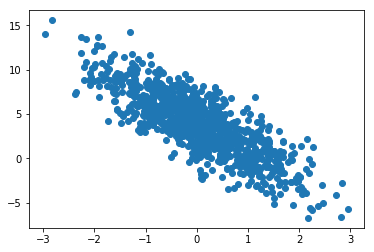

In [3]:
#使用线性模型来生成数据集
num_inputs = 2#features number
num_examples = 1000
w_true = [2,-3]
b_true = 4

features = torch.randn(num_examples,num_inputs,dtype=torch.float32)
labels = w_true[0]*features[:,0]+w_true[1]*features[:,1]+b_true
labels =labels+torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)

plt.scatter(features[:,1].numpy(),labels.numpy());

In [4]:
#读取数据集
import random
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)#将列表的元素顺序随机打乱
    for i in range(0,num_examples,batch_size):
        #range(s,e,step)返回的是range型可迭代对象，不可变列表  np.arange()返回的是ndarray
        j = torch.LongTensor(indices[i:min(i+batch_size,num_examples)])#min是防止最后凑不齐一个batch
        #j是一个tensor
        yield features.index_select(0,j),labels.index_select(0,j)
        #index_select是pytorch中的方法，第一个参数为0表示按行索引，第二个参数是一个tensor表示筛选的序号
        
batch_size = 10
for x,y in data_iter(batch_size,features,labels):
    print (x,'\n',y)
    break
    
#pytorch版
import torch.utils.data as Data
dataset = Data.TensorDataset(features,labels)#拼接
data_iter2 = Data.DataLoader(dataset=dataset,
                            batch_size=10,
                            shuffle=True,
                            num_workers=2,
                           )
for x,y in data_iter2:
    print (x,'\n',y)
    break

tensor([[-1.0885, -0.3192],
        [ 1.6246, -0.5499],
        [ 0.5785, -0.6107],
        [-0.1618, -2.2074],
        [-0.1784,  0.1130],
        [-0.8291, -0.4109],
        [ 0.0366,  0.5840],
        [-0.2352, -0.0817],
        [-0.8002,  0.4082],
        [ 0.7293, -0.9986]]) 
 tensor([ 2.7797,  8.9019,  7.0044, 10.3036,  3.2998,  3.6007,  2.3211,  3.7599,
         1.1733,  8.4775])
tensor([[-0.8454,  0.0910],
        [-0.6916, -1.6284],
        [ 0.3923,  0.5202],
        [-0.3942, -1.0497],
        [-0.5952,  0.3450],
        [-1.1656, -0.3322],
        [ 0.7279, -0.0150],
        [ 1.3871,  0.4192],
        [ 0.3237, -0.8523],
        [-0.3855,  1.1122]]) 
 tensor([ 2.0362,  7.5053,  3.2431,  6.3554,  1.7904,  2.6781,  5.4998,  5.5315,
         7.2083, -0.1101])


In [5]:
#初始化模型参数
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype=torch.float32)
b = torch.zeros(1,dtype=torch.float32,requires_grad=True)
#所有的tensor都有requires_grad属性，等于True可自动求导
#所有的tensor都有requires_grad_方法可以改变requires_grad属性
w.requires_grad_(requires_grad=True)
#b.requires_grad_(requires_grad=True)
b


tensor([0.], requires_grad=True)

In [6]:
#定义模型
def linreg(x,w,b):
    return torch.mm(x,w)+b

#pytorch版 定义模型
from torch import nn
class LinearNet(nn.Module):
    def __init__(self,n_feature):
        super(LinearNet,self).__init__()#继承父类的初始化
        self.linear = nn.Linear(n_feature,1)#输入
    def forward(self,x):
        y = self.linear(x)
        return y
print (LinearNet(num_inputs))
net = nn.Sequential(nn.Linear(num_inputs,1))#初始化多层网络
#初始化模型参数
from torch.nn import init

init.normal_(net[0].weight, mean=0.0, std=0.01)
init.constant_(net[0].bias, val=0.0)

for param in net.parameters():
    print (param)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Parameter containing:
tensor([[-0.0044, -0.0082]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [10]:
#定义损失函数
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.size()))**2/2

#
loss2 = nn.MSELoss()

In [12]:
#定义优化函数
def sgd(params,lr,batch_size):
    #y.backward()
    for param in params:
        param.data -= lr/batch_size*param.grad#梯度下降更新param
        #param.grad 对param求导。求y关于param的导数
        
#
import torch.optim as optim
optimizer = optim.SGD(net.parameters(),lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [14]:
#训练
lr = 0.03
num_epochs = 5
batch_size = 10
for epoch in range(num_epochs):
    for x,y in data_iter(batch_size,features,labels):
        y_hat = linreg(x,w,b)#调用模型
        loss = squared_loss(y_hat,y).sum()
        loss.backward()
        sgd([w,b],lr,batch_size)
        w.grad.data.zero_()#清零
        b.grad.data.zero_()
    train_loss = squared_loss(linreg(features,w,b),labels).mean()
    print('epoch %d,loss %f'%(epoch+1,train_loss.item()))
    
    
#
print ("\n使用pytorch框架简洁实现")
num_epochs = 3
for epoch in range(num_epochs):
    for x,y in data_iter2:
        output = net(x)
        l = loss2(output,y.view(-1,1))
        optimizer.zero_grad()#清零 net.zero_grad()
        l.backward()
        optimizer.step()
    print("epoch %d, loss: %f"%(epoch+1,l.item()))

epoch 1,loss 0.000048
epoch 2,loss 0.000048
epoch 3,loss 0.000049
epoch 4,loss 0.000048
epoch 5,loss 0.000049
使用pytorch框架简洁实现
epoch 1, loss: 0.000144
epoch 2, loss: 0.000062
epoch 3, loss: 0.000061
